In [2]:
import glob
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from astropy.io import fits
import torch.nn.functional as F

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
from tqdm import tqdm
import random

# Load and split images
DATA_DIR1 = "/gdrive/MyDrive/Planet Catchers/Temp Planet"
DATA_DIR2 = "/gdrive/MyDrive/Planet Catchers/Temp Planets"

X = []
y = []

labels = {
    "HD142527_11Apr13": [1, 0, 0, 0],
    "HD142527_8Apr14_long": [1, 0, 0, 0],
    "HD142527_8Apr14_short": [1, 0, 0, 0],
    "HD142527_15May15": [1, 0, 0, 0],
    "HD142527_16May15": [1, 0, 0, 0],
    "HD142527_18May15": [1, 0, 0, 0],
    "HD142527_10Feb17": [0, 0, 1, 0],
    "HD142527_27Apr18": [0, 0, 1, 0],
    "PDS70_8Feb17": [1, 0, 0, 1],
    "PDS70_2May18": [1, 0, 0, 1],
    "PDS70_3May18": [1, 0, 0, 1],
}

i = 0
img = None
files = list(glob.glob(f"{DATA_DIR1}/*.fits")) + list(glob.glob(f"{DATA_DIR2}/*.fits"))
random.shuffle(files)
files = files[0:500]
num_files = len(files)
for fpath in tqdm(files):
    if "_" not in fpath or "/" not in fpath:
      continue
    if "_".join(fpath.split("/")[-1].split("_")[0:2]) not in labels:
      continue
    data = fits.getdata(fpath)
    img = torch.from_numpy(data.astype(np.float32))
    img = torch.nan_to_num(img)
    shape = img.shape[1]
    img = img[:,:shape - 1, :shape - 1]
    w_h  = img.shape[1]
    shape = img.shape[1] // 2
    split = torch.split(img, (shape, shape), dim=1)
    megasplit = []
    for elem in split:
        split2 = torch.split(elem, (shape, shape), dim=2)
        megasplit.append(split2[0])
        megasplit.append(split2[1])
    X += megasplit
    y += labels["_".join(fpath.split("/")[-1].split("_")[0:2])]

# Order will be: top left, bottom left, top right, bottom right

y = torch.tensor(y)

100%|██████████| 500/500 [04:06<00:00,  2.03it/s]


In [5]:
X[1].shape

torch.Size([9, 225, 225])

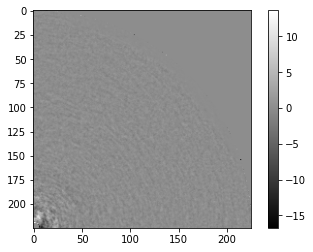

In [7]:
# Visualizing as sanity check
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(torch.split(X[2], 1, dim=0)[7].transpose(0, 2).squeeze(), cmap='gray')
plt.colorbar()
plt.show()

In [8]:
# Randomize orientations
import random
rots = [random.randint(0, 3) for _ in range(len(X))]
X = [torch.rot90(x, rot, [1, 2]) for rot, x in zip(rots, X)]

In [9]:
# Shuffle and split dataset
shuffler = np. random. permutation(len(X))
X = torch.stack([X[i] for i in shuffler])
y = torch.tensor([y[i] for i in shuffler])
X_train = X[0:int(len(X) * 0.8)]
X_test = X[int(len(X) * 0.8):]
y_train = y[0:int(len(y) * 0.8)]
y_test = y[int(len(y) * 0.8):]

In [14]:
from torch.utils.data import Dataset, DataLoader

class PlanetClassifierDataset(Dataset):
    def __init__(self, data, labels, train=True):
        self.data = data
        self.labels = labels
        self.train = train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_data = PlanetClassifierDataset(X_train, y_train)
test_data = PlanetClassifierDataset(X_test, y_test, train=False)

In [15]:
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device {device}")

Using device cuda


In [16]:
def check_accuracy(dataset, model):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [17]:
def train(model, optimizer, dataset, epochs=1):
    """
    Train a model PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        loss = None
        model.train()  # put model to training mode
        for x, y in DataLoader(dataset, batch_size=64, shuffle=True):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        print(f"Finished epoch (Loss: {loss})")

In [24]:
# ConvNet 3-layer architecture

learning_rate = 1e-2

size = (32 + 4 - 5) + 1
size = (size + 2 - 3) + 1
channel_1 = 32
channel_2 = 16

model = nn.Sequential(
    nn.Conv2d(9, channel_1, 5, padding=2),
    nn.ReLU(),
    nn.Conv2d(channel_1, channel_2, 3, padding=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(810000, 2)
)

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [25]:
train(model, optimizer, train_data, epochs=3)

Finished epoch (Loss: 0.4968951642513275)
Finished epoch (Loss: 0.09300889819860458)
Finished epoch (Loss: 0.03498115763068199)


In [26]:
check_accuracy(test_data, model)

Checking accuracy on test set
Got 334 / 339 correct (98.53)


In [ ]:
check_accuracy(train_data, model)

Checking accuracy on validation set
Got 473 / 473 correct (100.00)
